Are you ready for your first proof of quantum advantage? I'm not sure if you're ready for your first proof of quantum advantage.

Behold, the Deutsch, and later, the Deutsch-Jorza algorithm. 

In Deutsch's problem, we have a black box, or an oracle that computes a one-boolean function

$$ f: \{0,1\} @=> \{0,1\} $$

This might seem trivial, but the output might represent something exciting like the chosen route of a routing problem

There are exactly four kinds of one-input, one-output boolean functions

- $f_0$ which maps all inputs to to $0$
- $f_1$ which maps all inputs to to $1$
- $f_x$ which maps all inputs to itself
- $f_{x'}$ which maps all inputs to the opposite.

where $f_0$ and $f_1$ are constant functions, and $f_x$ and $f_{x'}$ are balanced (have the same number of 0's and 1's in their respective truth tables)

The problem is:

Given access to a one bit input and output boolean function, determine, by querying the function as little times as possible, whether the function is balanced or constant.

Classicaly, it would take us 2 queries to figure out which function we were dealing with. For an n-bit system, it would take us $n$ times.

Spoiler alert: With a QC it would only take us once - regardless of $n$. EXCITING!!!

Now to the implementation with

our circuit looks like this 
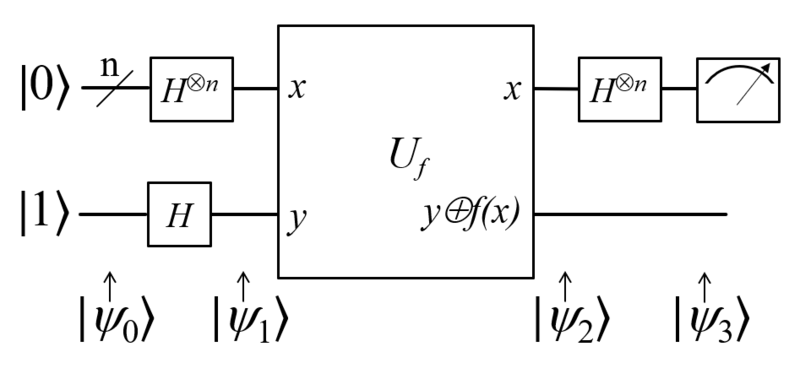


Also, to fully harness the power of the qubits, we will make our measurements in the hadamard basis instead of the standard computational basis.

Notice that $f_0$ and $f_1$ are constant functions and not reversible. For our QC implementation of this, we want to represent it as a reversible operation. The trick is to add an extra register and store in it either
1. The computed value
2. inputs to the function

We'll focus on 1). We can generalise these reversible functions as 

$$U_f(|x>|y>) := |x>|y \bigoplus f(x)>$$, where   is the XOR operator

If we plug this in for all 4 binary operators (exercise is left for the reader as it would take a long time to type out), we will see that the functions map to quantum operators

- $f_0$ === $I$ on system
- $f_1$ === $X$ (bit flip) on second qubit
- $f_x$ === $CNOT$ with first qubit as control, second as target
- $f_{x'}$ === $CNOT$ with first qubit as control, second as target, followed by $X$ on second qubit.

In [1]:
# Imports 
import cirq

In [6]:
# Get two qubits (a data qubit and target qubit) 
q0, q1 = cirq.LineQubit.range(2)

# Define the oracle's dictionary
oracles = {
    '0': [],
    '1': [cirq.X(q1)],
    'x': [cirq.CNOT(q0, q1)],
    'notx': [cirq.CNOT(q0, q1), cirq.X(q1)]
}

Looking at the truth tables of our 4 unitary operators, it becomes apparent that we cannot determine balanced from constant functions by using the oracle only once, as the answers are not unique. But we can, if we make the second target qubit in superposition state.

   $$ |-> = \frac{1}{\sqrt{2}} (|0> - |1>) $$
   
Applying the operator $U_f$ to this, we can see that 


$$ U_f|x>|-> = (-1)^{f(x)}|x>|-> $$

Which is called the phase kickback trick. It puts the information we need to decide whether the function is constant or balanced in the phase! 

But, how can we ues this phase to distinguish between the functions? Note that for phase for constant functions is the same for all $|x>$, whereas it is different for balanced functions. 

With this system, the functions would act like gates on the first qubit:

- $f_0$ = $I$
- $f_1$ = $-I$
- $f_x$ = $Z$
- $f_{x'}$ = $-Z$


So, we need to distinguish between the identity gate and the Z gate on the first qubit to tell the function's type. But, the Z-gate is rotational and not easily identifiable. instead, let's use the identity

$$ HZH = X $$ 
$$ HIH = I $$ 

So, if we apply the a hadamard gate before and after the function, we can tell that the function is constant if the bit is the same, and balanced if the bit is flipped! 

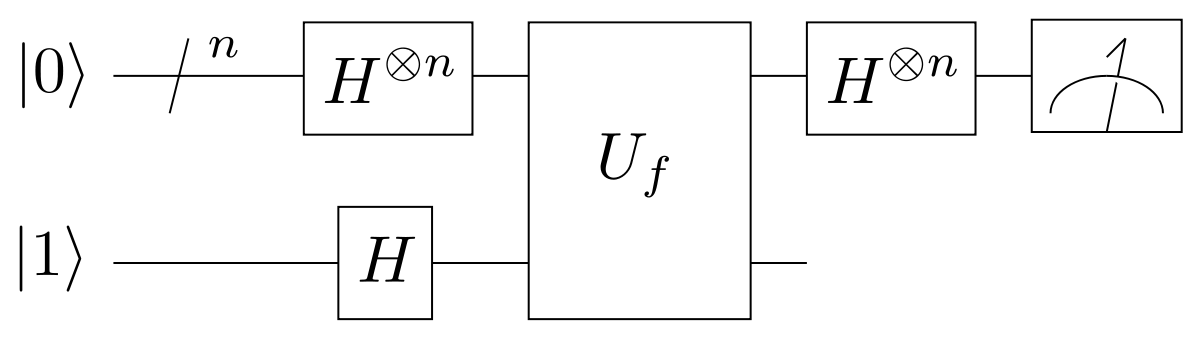

(circuit shown generalised for n bits)

In [11]:
## Yields circuit for Deustch's algorithm 
## Yield makes it a generator function - think of a normal function, but with a preserved state
def deutsch_algorithm(oracle):
    yield cirq.X(q1)
    yield cirq.H(q0), cirq.H(q1)
    yield oracle
    yield cirq.H(q0)
    yield cirq.measure(q0)
    
    # Dispay each circuit for all oracles
for key, oracle in oracles.items():
    print('Circuit for {}...' .format(key))
    print(cirq.Circuit(deutsch_algorithm(oracle))),
    end="\n\n"

Circuit for 0...
0: ───H───H───M───

1: ───X───H───────
Circuit for 1...
0: ───H───H───M───

1: ───X───H───X───
Circuit for x...
0: ───H───────@───H───M───
              │
1: ───X───H───X───────────
Circuit for notx...
0: ───H───────@───H───M───
              │
1: ───X───H───X───X───────


In [13]:
# Get a simulator
simulator = cirq.Simulator()

# Execute circuit for each oracle to distinguish constant from balanced
for key, oracle in oracles.items():
    result = simulator.run(
        cirq.Circuit(deutsch_algorithm(oracle)),
        repetitions=10
    )
    
    print('oracle: {:<4} results: {}' .format(key, result))

oracle: 0    results: 0=0000000000
oracle: 1    results: 0=0000000000
oracle: x    results: 0=1111111111
oracle: notx results: 0=1111111111


Now, let's generalise for n-bits. We would have 2 constant functions, $f(x_0, x_1) = 0$ and $f(x_0, x_1) = 1$

And 6 balanced functions

In [21]:
q2, q3, q4 = cirq.LineQubit.range(3)

# Oracles for constant functions
constant = ([], cirq.X(q2))
# Oracles for balanced functions
balanced = (
    [cirq.CNOT(q2, q4)],
    [cirq.CNOT(q3, q4)],
    [cirq.CNOT(q2, q4), cirq.CNOT(q3, q4)],
    [cirq.CNOT(q2, q4), cirq.X(q4)],
    [cirq.CNOT(q3, q4), cirq.X(q4)],
    [cirq.CNOT(q2, q4), cirq.CNOT(q3, q4), cirq.X(q4)],
)

## Yields circuit for Deustch's algorithm for n=3 qubits
def n_deustch_algorithm(oracle):
    # Phase kickback trick
    yield cirq.X(q4), cirq.H(q4)
    
    # Equal superposition over input bits
    yield cirq.H(q2), cirq.H(q3)
    
    # Query the function
    yield oracle
    
    # Interference to get result, put last qubit into |1>
    yield cirq.H(q2), cirq.H(q3), cirq.H(q4)
    
    # Final OR gate to put result in final qubit
    yield cirq.X(q2), cirq.X(q3), cirq.CCX(q2, q3, q4)
    yield cirq.measure(q4)
    

In [22]:
# Get simulator
sim = cirq.Simulator()

# Execute circuit for oracles of constant value functions
print('Your result on constant functions')
for oracle in constant: 
    result = simulator.run(cirq.Circuit(n_deustch_algorithm(oracle)), repetitions=10)
    print(result)
    
# Execute circuit for oracles of balanced value functions
print('Your result on balanced functions')
for oracle in balanced: 
    result = simulator.run(cirq.Circuit(n_deustch_algorithm(oracle)), repetitions=10)
    print(result)

Your result on constant functions
2=0000000000
2=0000000000
Your result on balanced functions
2=1111111111
2=1111111111
2=1111111111
2=1111111111
2=1111111111
2=1111111111
